In [1]:
# Try to figure out wind reconstruction

In [108]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import downscaling as ds

In [239]:
can07_u, can07_v = ds.import_CANRCM_winds(2007)

In [156]:
can07_u.lon.values[13, 16]

235.94528198242188

6380.8145


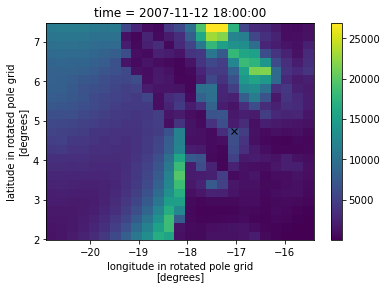

In [192]:
can07_v[nit].plot();
iv = 12
iu = 17
plt.plot(can07_u.rlon.values[iu], can07_u.rlat.values[iv], 'kx');
print (can07_v[nit, iv, iu].values)

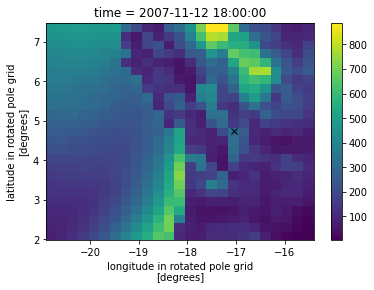

In [193]:
nspeed = (can07_u**2  + can07_v**2)**(1/3)
nangle = np.arctan2(can07_v, can07_u)
v = nspeed * np.sin(nangle)
v[nit].plot();
plt.plot(can07_u.rlon.values[iu], can07_u.rlat.values[iv], 'kx');

In [288]:
hr07_u, hr07_v = ds.import_HRDPS_winds(2007)

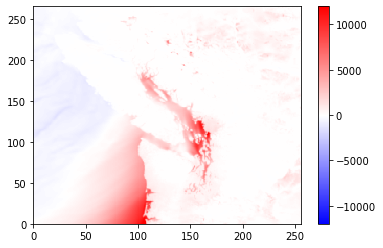

In [198]:
plt.pcolormesh(hr07_v[nit], cmap='bwr', vmin=-12000, vmax=12000);
plt.colorbar();

In [201]:
print (0.625*24)
nit/8+1

15.0


314.625

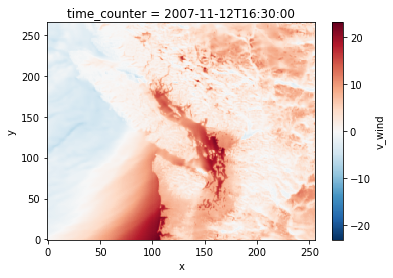

In [222]:
vector3avg = xr.open_dataset('./ncfiles/vector3avg_y2007m11d12.nc')
iday = 5
vector3avg.v_wind[iday].plot()
#vector3avg.v_wind[:, 10, 100].plot()

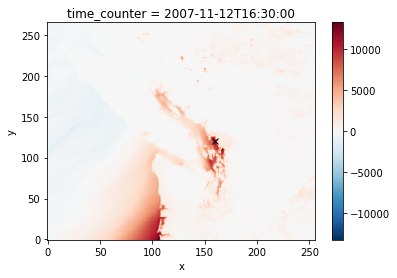

In [261]:
cubed = (vector3avg.u_wind[iday]**2 + vector3avg.v_wind[iday]**2)**1.5
angle = np.arctan2(vector3avg.v_wind[iday], vector3avg.u_wind[iday])
vu3 = cubed * np.cos(angle)
vv3 = cubed * np.sin(angle)
vv3.plot();
plt.plot(160, 120, 'kx')

Looking identical!  All good.

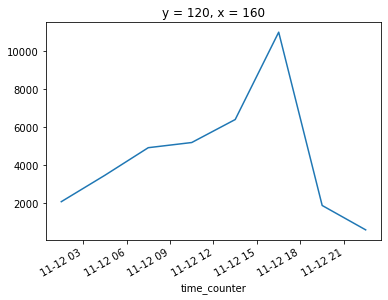

In [263]:
cubed = (vector3avg.u_wind[:]**2 + vector3avg.v_wind[:]**2)**1.5
angle = np.arctan2(vector3avg.v_wind[:], vector3avg.u_wind[:])
vu3 = cubed * np.cos(angle)
vv3 = cubed * np.sin(angle)
vv3[:, 120, 160].plot()

In [224]:
can07_mat = ds.transform2(can07_u, can07_v)
del can07_u
del can07_v
can07_PCs, can07_eigs, can07_mean = ds.doPCA(100, can07_mat)
del can07_mat

In [225]:
hr07_mat = ds.transform2(hr07_u, hr07_v)
del hr07_u
del hr07_v
hr07_PCs, hr07_eigs, hr07_mean = ds.doPCA(100, hr07_mat)
del hr07_mat

In [226]:
can07_me = np.concatenate((can07_mean.reshape(1, -1), can07_eigs))
hr07_me = np.concatenate((hr07_mean.reshape(1, -1), hr07_eigs))
del can07_eigs
del hr07_eigs

Reconstruct Can RCM results

In [229]:
myr = 65
reconC = np.matmul(can07_PCs[:,0:myr], can07_me[1:myr+1, nit-5:nit+3]) + can07_me[0, nit-5:nit+3]

2549.6697


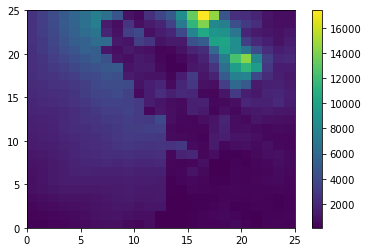

In [251]:
myrecon = ds.reverse(reconC, (-1, 25, 25))
plt.pcolormesh(myrecon[15])
plt.colorbar();
print (myrecon[8+5, iv, iu])

Reconstruction is pretty sucky.

In [257]:
print (can07_u[nit, iv, iu].values, myrecon[10, iv, iu])

-6184.9497 -6427.8867


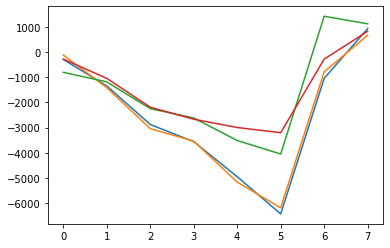

In [268]:
plt.plot(myrecon[::2, iv, iu]);
plt.plot(can07_u[nit-5:nit+3, iv, iu]);
plt.plot(vu3[:, 120, 160]);
plt.plot(u_data_rec[nit-5:nit+3, 120, 160]);

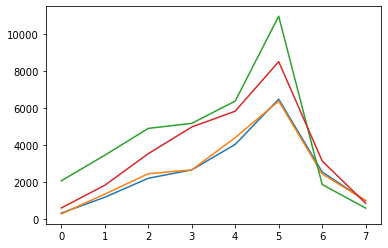

In [267]:
plt.plot(myrecon[1::2, iv, iu]);
plt.plot(can07_v[nit-5:nit+3, iv, iu]);
plt.plot(vv3[:, 120, 160]);
plt.plot(v_data_rec[nit-5:nit+3, 120, 160]);

Sweet!

In [258]:
coefs = ds.getCoefs(can07_me, 65 + 1, hr07_me, 65 + 1, type = 'LS')

In [259]:
##calculating average of rows
canTY_u, canTY_v = ds.import_CANRCM_winds(2007)
print ('step 0')
canTY_mat = ds.transform2(canTY_u, canTY_v)
del canTY_u
del canTY_v
mean_TY = canTY_mat.mean(axis = 0)

step 0


In [260]:
u_data_rec, v_data_rec = ds.reconstruct2(canTY_mat, mean_TY, can07_PCs, 
                                      can07_me, hr07_PCs, hr07_me, 65, 65, method = 'LS')

In [269]:
u_data_rec.shape

(2904, 266, 256)

In [283]:
nspeed = (u_data_rec**2  + v_data_rec**2)**(1/6)
nangle = np.arctan2(v_data_rec, u_data_rec)

In [284]:
newu = nspeed * np.cos(nangle)
newv = nspeed * np.sin(nangle)

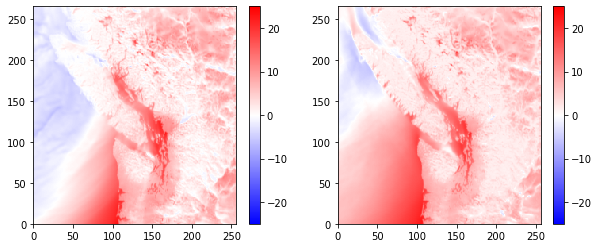

In [286]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
colours = axs[1].pcolormesh(newv[nit], cmap='bwr', vmin=-25, vmax=25)
fig.colorbar(colours, ax=axs[1]);
colours = axs[0].pcolormesh(vector3avg.v_wind[iday], cmap='bwr', vmin=-25, vmax=25)
fig.colorbar(colours, ax=axs[0]);

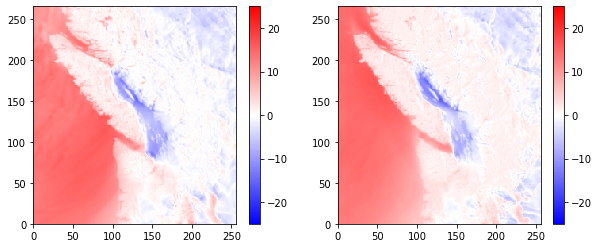

In [287]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
colours = axs[1].pcolormesh(newu[nit], cmap='bwr', vmin=-25, vmax=25)
fig.colorbar(colours, ax=axs[1]);
colours = axs[0].pcolormesh(vector3avg.u_wind[iday], cmap='bwr', vmin=-25, vmax=25)
fig.colorbar(colours, ax=axs[0]);

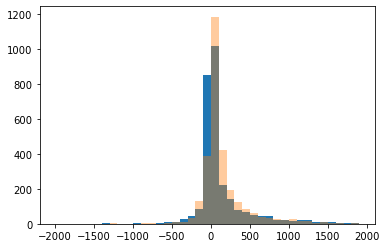

In [296]:
plt.hist(hr07_v[:, 120, 160], bins=np.arange(-2000, 2000, 100));
plt.hist(v_data_rec[:, 120, 160], bins=np.arange(-2000, 2000, 100), alpha=0.4);

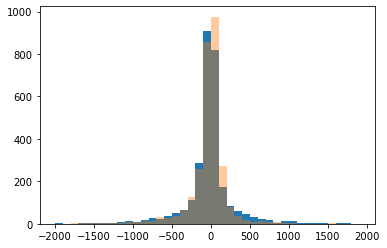

In [298]:
plt.hist(hr07_u[:, 120, 160], bins=np.arange(-2000, 2000, 100));
plt.hist(u_data_rec[:, 120, 160], bins=np.arange(-2000, 2000, 100), alpha=0.4);

In [303]:
np.abs(hr07_v[:, :, :]).mean()

157.84391360627674

In [304]:
np.abs(v_data_rec[:, :, :]).mean()

138.7910921648572

In [305]:
np.abs(hr07_u[:, :, :]).mean()

130.56226929131955

In [306]:
np.abs(u_data_rec[:, :, :]).mean()

111.29042352223705

In [307]:
print (np.abs(hr07_v[:, :, :]).mean()/np.abs(v_data_rec[:, :, :]).mean())

1.1372769760957602


In [308]:
print (np.abs(hr07_u[:, :, :]).mean()/np.abs(u_data_rec[:, :, :]).mean())

1.1731671527445646


In [309]:
print (np.abs(hr07_v[:, 120, 160]).mean()/np.abs(v_data_rec[:, 120, 160]).mean())

1.0521842662305325


In [310]:
print (np.abs(hr07_u[:, 120, 160]).mean()/np.abs(u_data_rec[:, 120, 160]).mean())

1.3207742427349456


So multiply up by 15%